Math 5750/6880: Mathematics of Data Science \
Project 2

# 1. Clustering Gaussian Blobs using $k$-means

In [ ]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# Generate 5 Gaussian blobs in 10 dimensions
X, y_true = make_blobs(
    n_samples=1000,
    centers=5,
    n_features=10,
    cluster_std=1.5,
    random_state=1)        # reproducibility
X = StandardScaler().fit_transform(X)

print(type(X),X.shape)
print(type(y_true),y_true.shape)

<class 'numpy.ndarray'> (1000, 10)
<class 'numpy.ndarray'> (1000,)


report smallest k-means inertia value, 2d visualization via PCA, confusion matrix, elbow analysis

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=5).fit(X)
y_pred = kmeans.labels_ # labels of each point
# Sum of squared distances of samples to their closest cluster center, weighted by the sample weights if provided
inertia_k5 = kmeans.inertia_

print(f"smallest k means inertia for k=5:  {inertia_k5:.3f}\n")

smallest k means inertia for k=5:  924.316



In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)
centers_pca = pca.transform(kmeans.cluster_centers_)

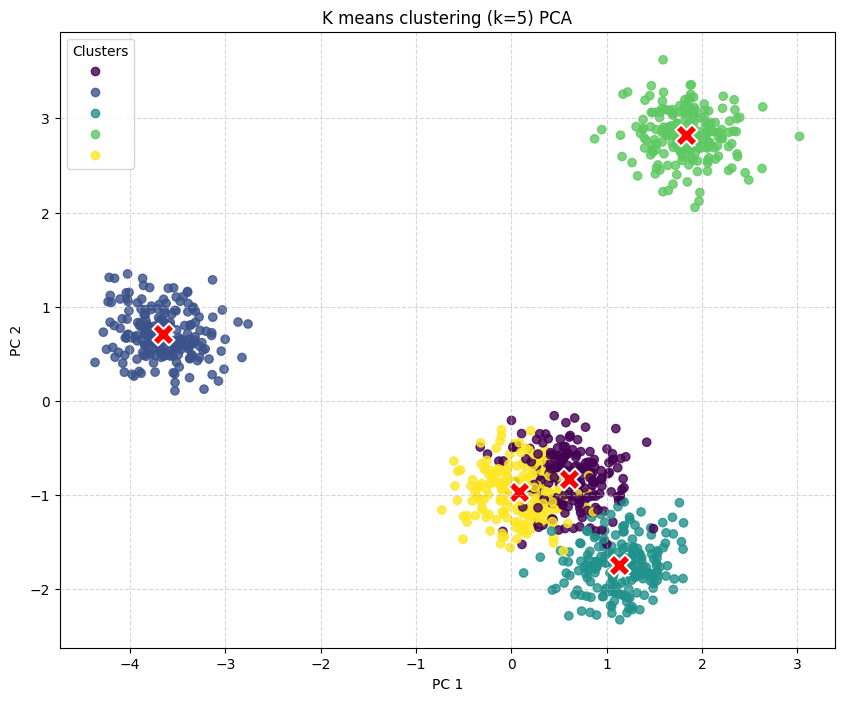

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=y_pred,
    cmap='viridis',
    alpha=0.8,
    # edgecolors='k',
    linewidth=1
)

plt.scatter(
    centers_pca[:, 0],
    centers_pca[:, 1],
    c='red',
    # alpha=0.1,
    marker='X',
    s=250,
    edgecolors='white',
    linewidth=1.5,
    label='Cluster Centers'
)

plt.title('K means clustering (k=5) PCA')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(handles=scatter.legend_elements()[0], title='Clusters')
plt.grid(True, linestyle='--', alpha=0.5)

Text(95.72222222222221, 0.5, 'True label')

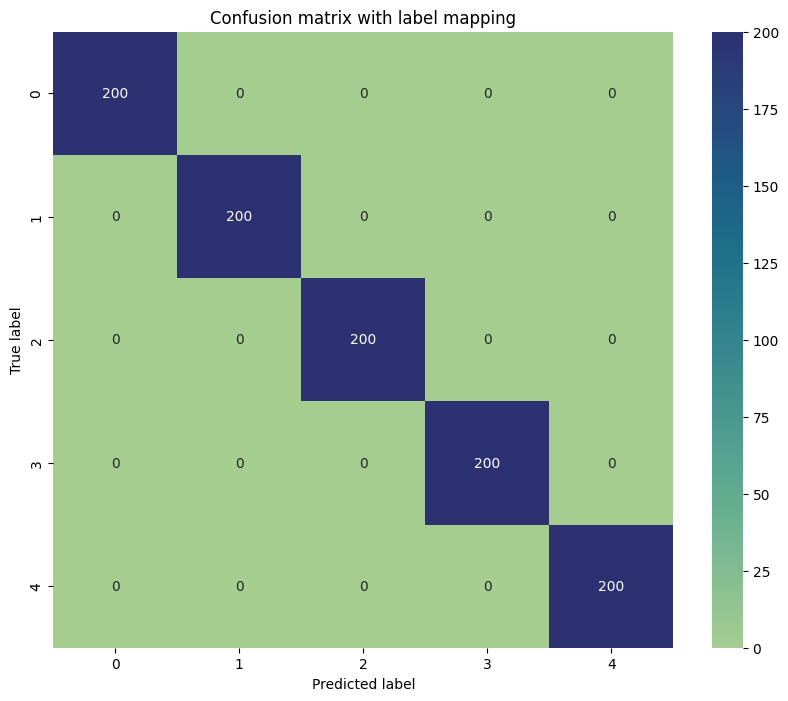

In [ ]:
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
import seaborn as sns

cm_unmapped = confusion_matrix(y_true, y_pred)
rows, cols = linear_sum_assignment(-cm_unmapped)
label_mapping = {cols[i]: rows[i] for i in range(len(cols))}
y_pred_mapped = np.array([label_mapping[label] for label in y_pred])
cm_mapped = confusion_matrix(y_true, y_pred_mapped)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_mapped,
    annot=True,
    fmt='d',
    cmap='crest',
    xticklabels=range(5),
    yticklabels=range(5)
)
plt.title('Confusion matrix with label mapping')
plt.xlabel('Predicted label')
plt.ylabel('True label')

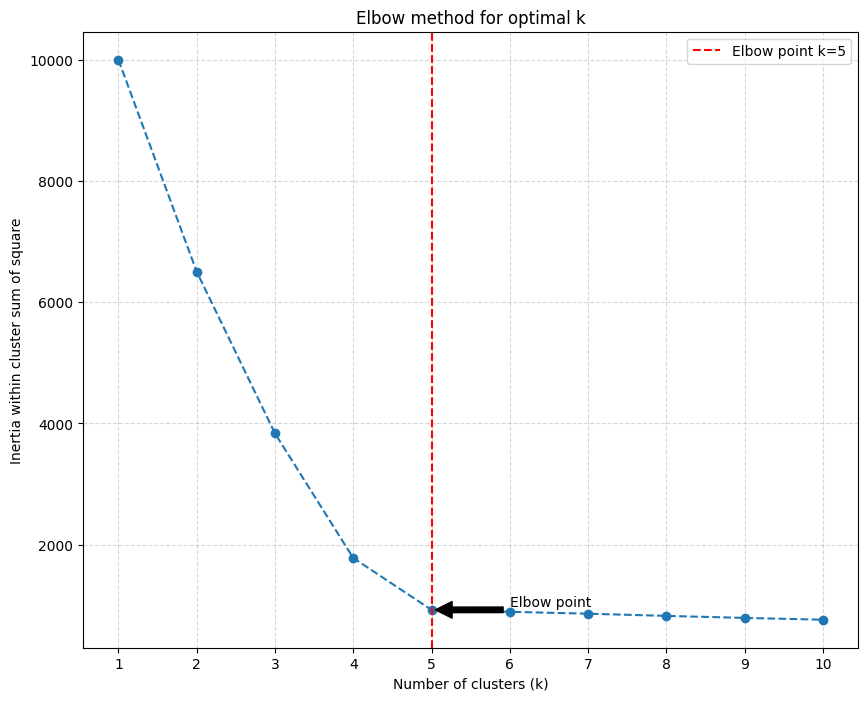

In [ ]:
# elbow analysis

inertia_values = []
k_range = range(1, 11)

for k in k_range:
  kmeans_elbow = KMeans(n_clusters=k, random_state=42)
  kmeans_elbow.fit(X)
  inertia_values.append(kmeans_elbow.inertia_)

plt.figure(figsize=(10, 8))
plt.plot(k_range, inertia_values, marker='o', linestyle='--')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia within cluster sum of square')
plt.title('Elbow method for optimal k')
plt.xticks(k_range)
plt.axvline(x=5, color='red', linestyle='--', label='Elbow point k=5')
plt.annotate('Elbow point', xy=(5, inertia_values[4]), xytext=(6, inertia_values[4] + 50),
                                arrowprops=dict(facecolor='black', shrink=0.05))
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# 2. Clustering Fashion-MNIST using $k$-means

In [24]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler

# Load Fashion-MNIST from OpenML
# Classes (0-9): T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot
X, y = fetch_openml("Fashion-MNIST", version=1, as_frame=False, parser="auto", return_X_y=True)
y = y.astype(int)

print(type(X),X.shape)
print(type(y),y.shape)

<class 'numpy.ndarray'> (70000, 784)
<class 'numpy.ndarray'> (70000,)


k-means cluster , center/scaling, reduce dimensions. fashion mnist has 10 categories

In [25]:
np.random.seed(42)
sample_size = 10000
random_indices = np.random.choice(X.shape[0], sample_size, replace=False)
X_sample = X[random_indices]
y_sample = y[random_indices]

print('sample shape', X_sample.shape)

sample shape (10000, 784)


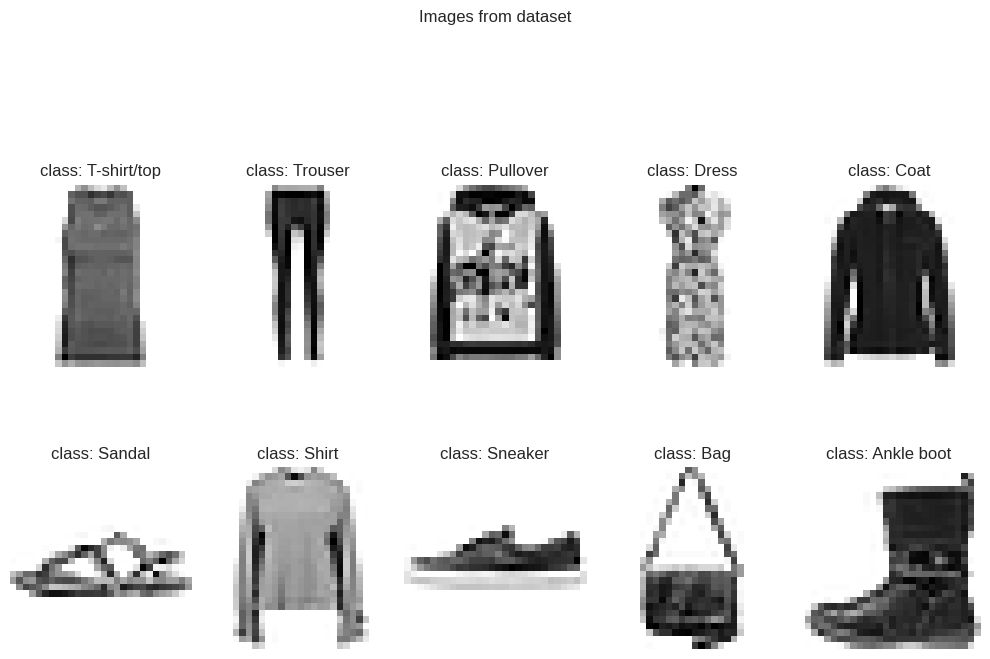

In [26]:
import matplotlib.pyplot as plt

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(10,8))
plt.suptitle('Images from dataset')
for i in range(10):
  ax = plt.subplot(2, 5, i+1)
  img_idx = np.where(y_sample == i)[0][0]
  plt.imshow(X_sample[img_idx].reshape(28, 28), cmap='binary')

  plt.title(f"class: {class_names[i]}")
  plt.axis('off')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [28]:
# reduce 28x28 dimensions for k-means clustering

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    # ('pca', PCA(n_components='mle')),
    ('kmeans', KMeans(n_clusters=10, random_state=42))
])

pipeline.fit(X_sample)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.95)),
                ('kmeans', KMeans(n_clusters=10, random_state=42))])

In [29]:
kmeans = pipeline.named_steps['kmeans']
centroids_pca = kmeans.cluster_centers_

pca = pipeline.named_steps['pca']
scaler = pipeline.named_steps['scaler']
centroids_original_space = pca.inverse_transform(centroids_pca)
centroids_images = scaler.inverse_transform(centroids_original_space)

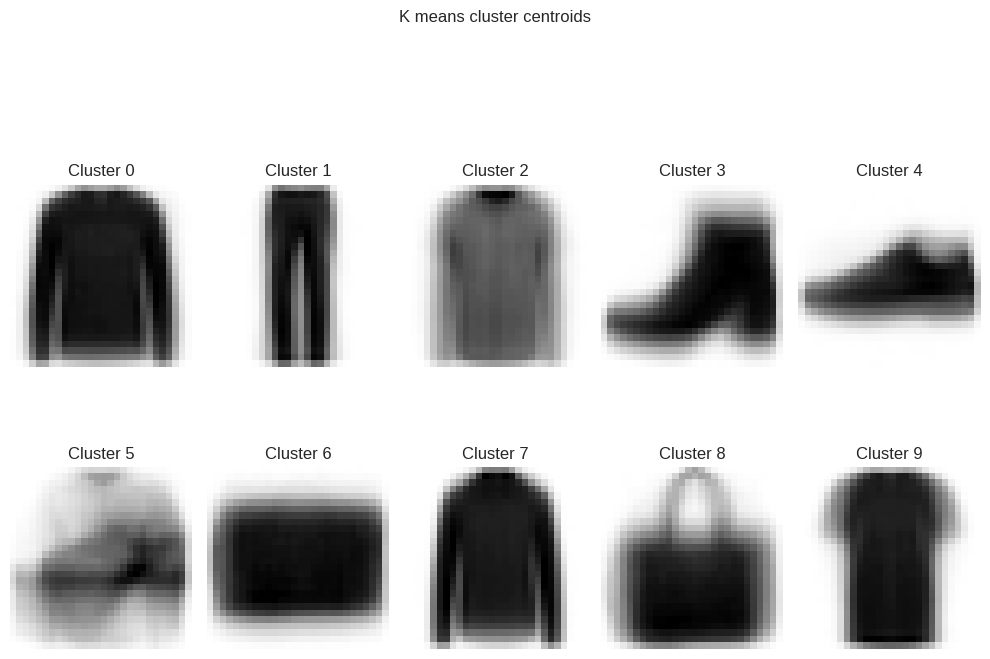

In [36]:
plt.figure(figsize=(10, 8))
plt.suptitle('K means cluster centroids')
for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    plt.imshow(centroids_images[i].reshape(28, 28), cmap='binary')
    plt.title(f"Cluster {i}")
    plt.axis("off")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

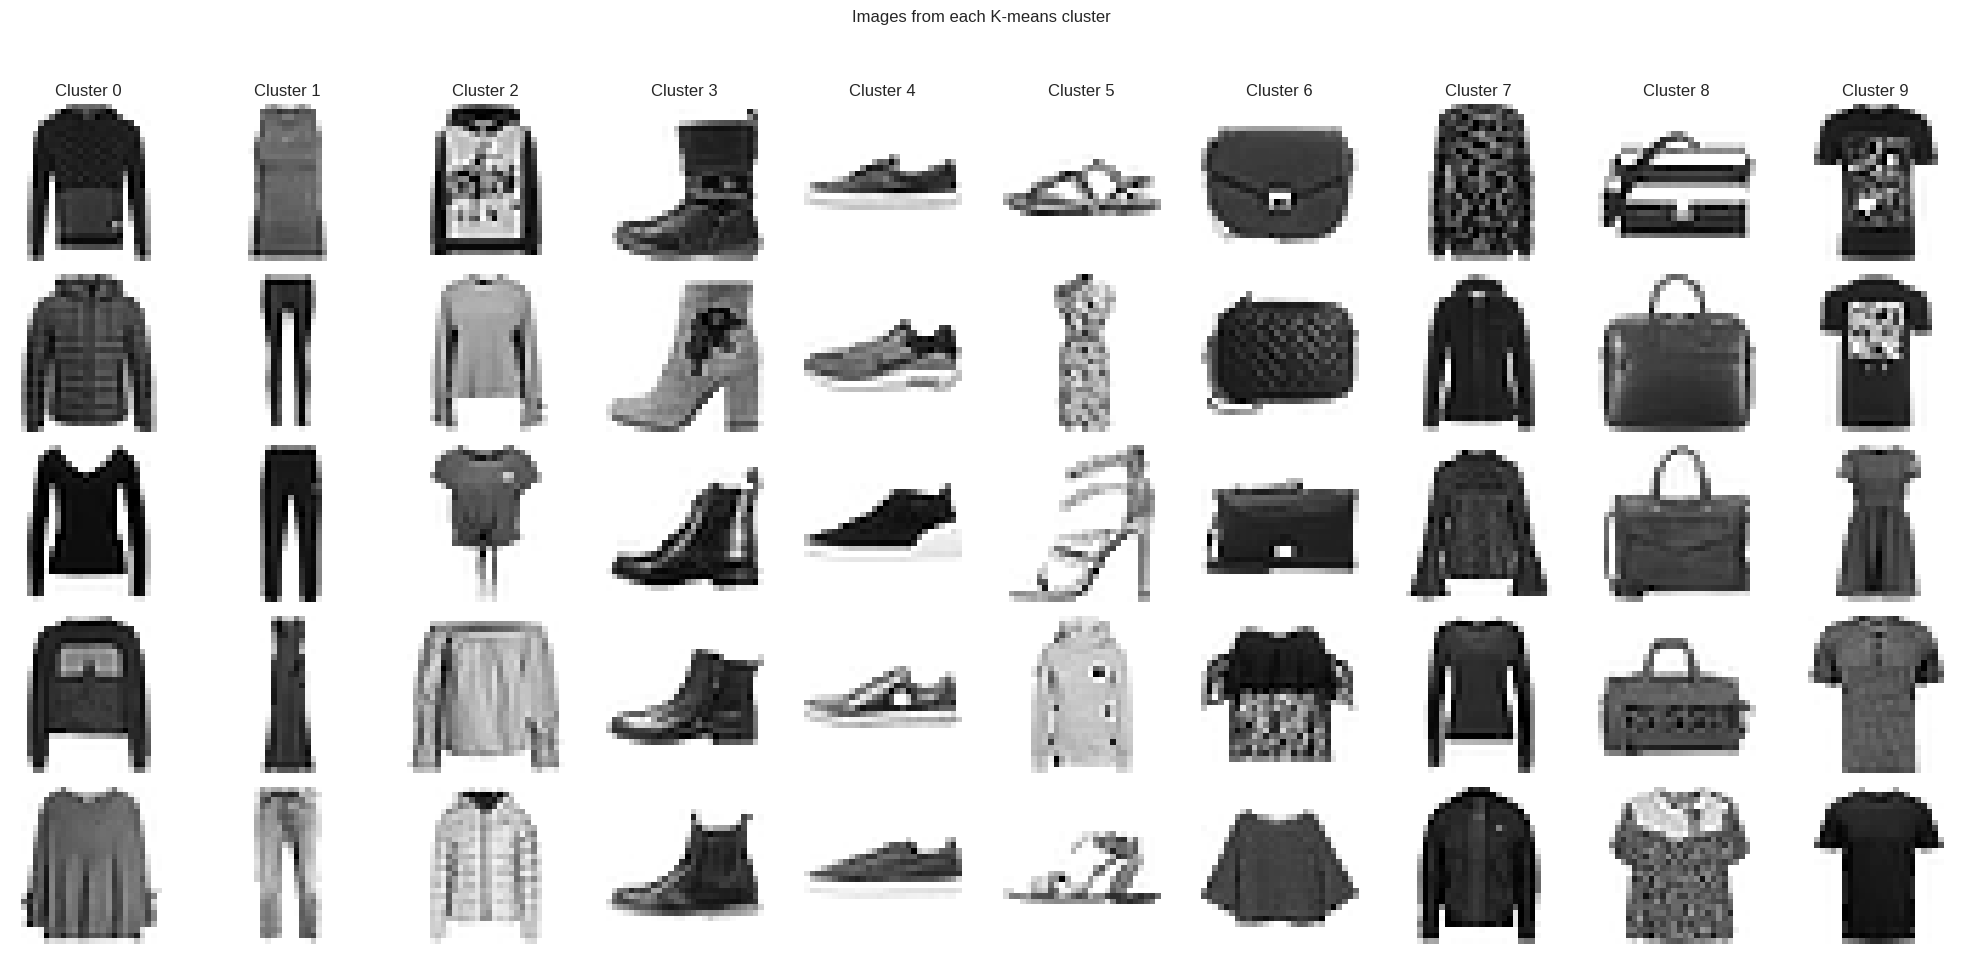

In [31]:
labels = kmeans.labels_
fig, axs = plt.subplots(5, 10, figsize=(20, 10))
fig.suptitle('Images from each K-means cluster')

for cluster_id in range(10):
    indices_in_cluster = np.where(labels == cluster_id)[0]
    if len(indices_in_cluster) > 0:
        samples = indices_in_cluster[:5]  # up to 5 examples per cluster
        for i, sample_idx in enumerate(samples):
            axs[i, cluster_id].imshow(X_sample[sample_idx].reshape(28, 28), cmap='binary')
            axs[i, cluster_id].axis('off')
            if i == 0:
                axs[i, cluster_id].set_title(f"Cluster {cluster_id}")
        for i in range(len(indices_in_cluster), 5):
            axs[i, cluster_id].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

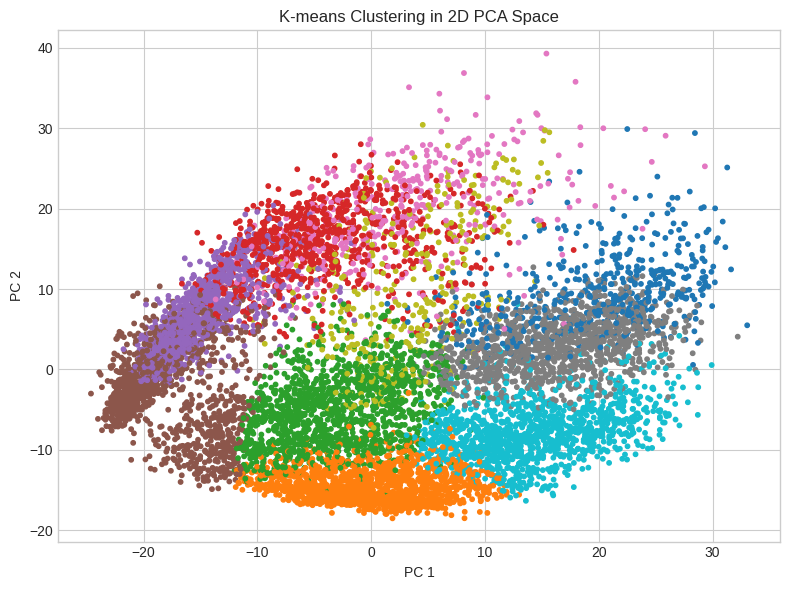

In [33]:
X_scaled = StandardScaler().fit_transform(X_sample)
X_pca_2d = PCA(n_components=2).fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=labels, cmap='tab10', s=10)
plt.title("K-means Clustering in 2D PCA Space")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.tight_layout()

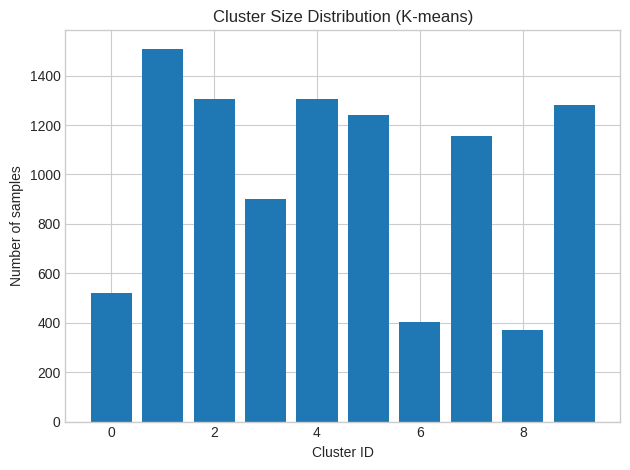

In [34]:
unique, counts = np.unique(labels, return_counts=True)
plt.bar(unique, counts)
plt.xlabel("Cluster ID")
plt.ylabel("Number of samples")
plt.title("Cluster Size Distribution (K-means)")
plt.tight_layout()

# 3. Dimensionality reduction for Fashion-MNIST



compare PCA and random projection on fashion-mnist dataset. Johnson-lindenstrauss Lemma. target dimensions k=1-,20,50,100,200. for each, compute correlation. plot correlation vs k for both methods

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.metrics import pairwise_distances
from sklearn.pipeline import Pipeline
from scipy.stats import pearsonr

In [17]:
fashion_mnist = fetch_openml('Fashion-MNIST', version=1, cache=True, as_frame=False)
n_samples = 2000
X = fashion_mnist.data
random_indices = np.random.permutation(X.shape[0])
X_sample = X[random_indices[:n_samples]]

print('data shape', X_sample.shape)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sample)

data shape (2000, 784)


In [18]:
# pairwise distance in the original space
dist_orig_matrix = pairwise_distances(X_scaled, metric='euclidean') # computes square matrix of distances
indices = np.triu_indices(n_samples, k=1)
dist_orig_vec = dist_orig_matrix[indices]

In [19]:
target_dims = [10, 20, 50, 100, 200]
pca_correlations = []
rp_correlations = []
pca_reconstruction_errors = []

for k in target_dims:
  pca = PCA(n_components=k, random_state=42)
  X_pca = pca.fit_transform(X_scaled)
  dist_pca_matrix = pairwise_distances(X_pca, metric='euclidean')
  dist_pca_vec = dist_pca_matrix[indices]
  pca_corr, _ = pearsonr(dist_orig_vec, dist_pca_vec)
  pca_correlations.append(pca_corr)

  X_reconstructed = pca.inverse_transform(X_pca)
  mse = np.mean((X_scaled - X_reconstructed) ** 2)
  pca_reconstruction_errors.append(mse)

  rp = GaussianRandomProjection(n_components=k, random_state=42)
  X_rp = rp.fit_transform(X_scaled)
  dist_rp_matrix = pairwise_distances(X_rp, metric='euclidean')
  dist_rp_vec = dist_rp_matrix[indices]
  rp_corr, _ = pearsonr(dist_orig_vec, dist_rp_vec)
  rp_correlations.append(rp_corr)

  print(f"k = {k:3d}\n | PCA correlation: {pca_corr:.3f}\n | RP correlation: {rp_corr:.3f}\n")

k =  10
 | PCA correlation: 0.915
 | RP correlation: 0.809

k =  20
 | PCA correlation: 0.954
 | RP correlation: 0.882

k =  50
 | PCA correlation: 0.985
 | RP correlation: 0.954

k = 100
 | PCA correlation: 0.996
 | RP correlation: 0.977

k = 200
 | PCA correlation: 0.999
 | RP correlation: 0.986



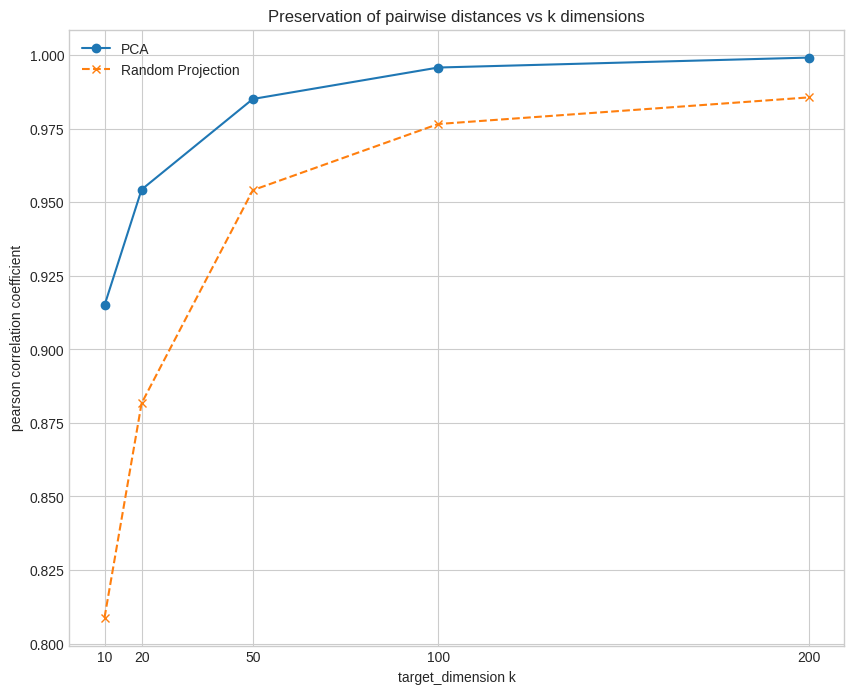

In [20]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(target_dims, pca_correlations, marker='o', linestyle='-', label='PCA')
ax.plot(target_dims, rp_correlations, marker='x', linestyle='--', label='Random Projection')
ax.set_title('Preservation of pairwise distances vs k dimensions')
ax.set_xlabel('target_dimension k')
ax.set_ylabel('pearson correlation coefficient')
ax.set_xticks(target_dims)
ax.legend()
ax.grid(True)

# 4. Clustering Fashion-MNIST using spectral clustering



compare with Question 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.pipeline import Pipeline

In [8]:
X, y = fetch_openml("Fashion-MNIST", version=1, as_frame=False, parser="auto", return_X_y=True)
y = y.astype(int)

np.random.seed(42)
sample_size = 1500
random_indices = np.random.choice(X.shape[0], sample_size, replace=False)
X_sample = X[random_indices]
y_sample = y[random_indices]

print('dataset shape', X.shape)
print('sampled shape', X_sample.shape)

dataset shape (70000, 784)
sampled shape (1500, 784)


In [12]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    # ('spectral', SpectralClustering(n_clusters=10, random_state=42))
    ('spectral', SpectralClustering(n_clusters=10, affinity='nearest_neighbors', random_state=42)) #  10 different centroid seeds
])

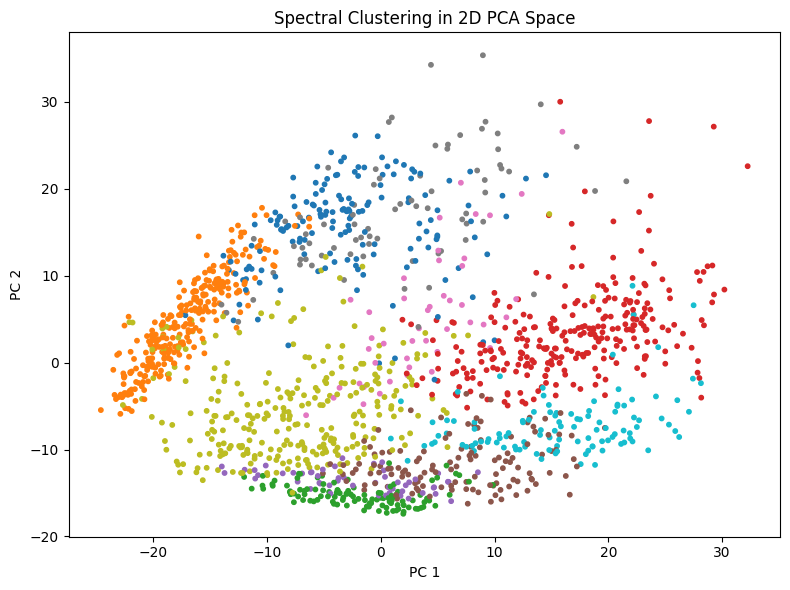

In [13]:
pipeline.fit(X_sample)
labels = pipeline.named_steps['spectral'].labels_

pca_2d = PCA(n_components=2)
X_scaled = StandardScaler().fit_transform(X_sample)
X_pca_2d = pca_2d.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=labels, cmap='tab10', s=10)
plt.title("Spectral Clustering in 2D PCA Space")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.tight_layout()
plt.show()

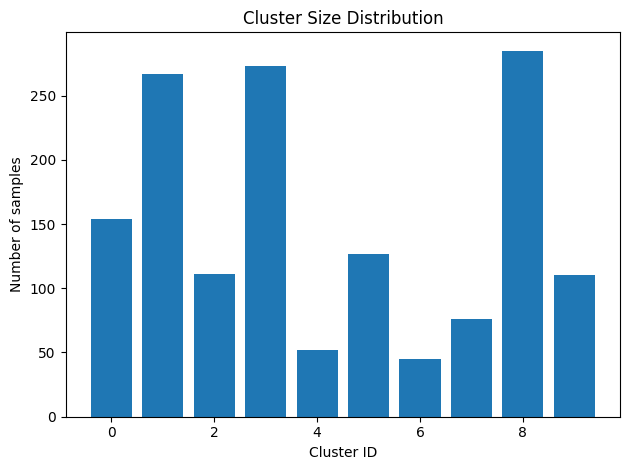

In [14]:
# Cluster size distribution
unique, counts = np.unique(labels, return_counts=True)
plt.bar(unique, counts)
plt.xlabel("Cluster ID")
plt.ylabel("Number of samples")
plt.title("Cluster Size Distribution")
plt.tight_layout()
plt.show()

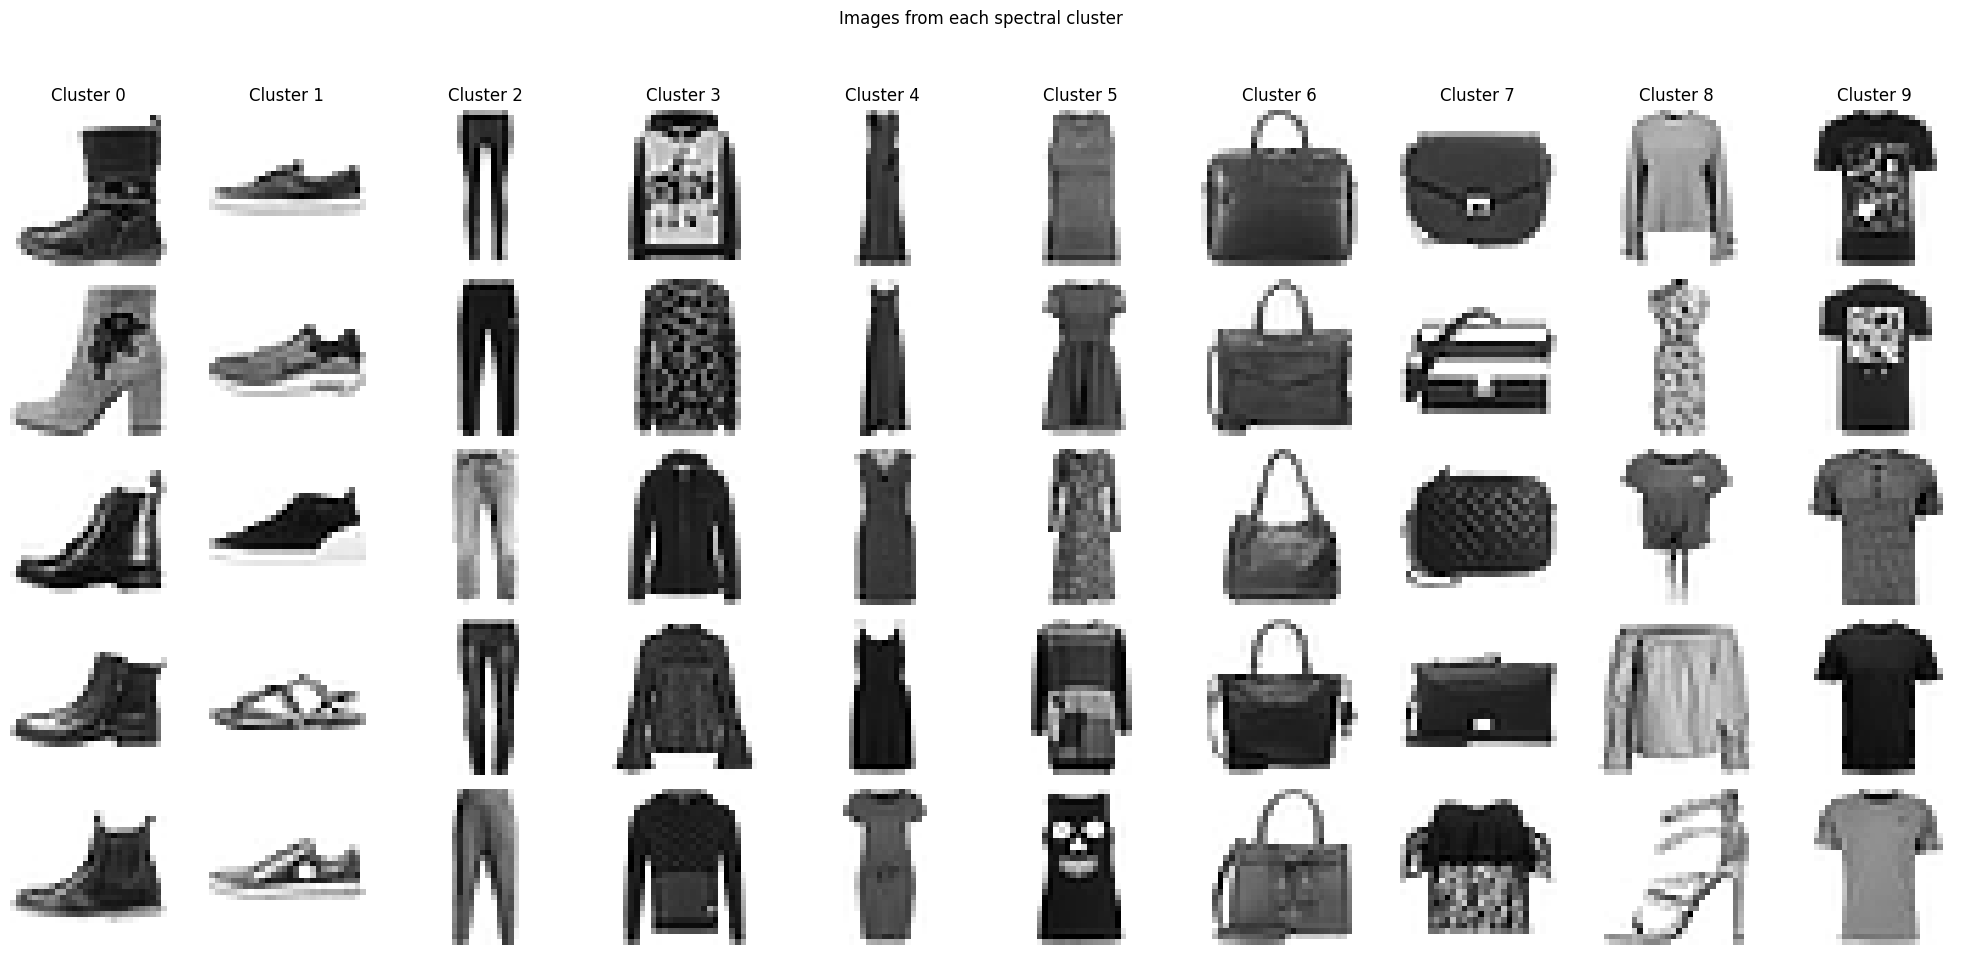

In [15]:
fig, axs = plt.subplots(5, 10, figsize=(20, 10))
fig.suptitle('Images from each spectral cluster')

for cluster_id in range(10):
    indices_in_cluster = np.where(labels == cluster_id)[0]
    if len(indices_in_cluster) > 0:
        samples = indices_in_cluster[:5]
        for i, sample_idx in enumerate(samples):
            axs[i, cluster_id].imshow(X_sample[sample_idx].reshape(28, 28), cmap='binary')
            axs[i, cluster_id].axis('off')
            if i == 0:
                axs[i, cluster_id].set_title(f"Cluster {cluster_id}")
        for i in range(len(indices_in_cluster), 5):
            axs[i, cluster_id].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()